<a href="https://colab.research.google.com/github/Magferat/Clustering-with-Neural-Networks/blob/main/DEC_Kmeans_CSE425.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:


import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import seaborn as sns
import pandas as pd

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 478kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.44MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.75MB/s]


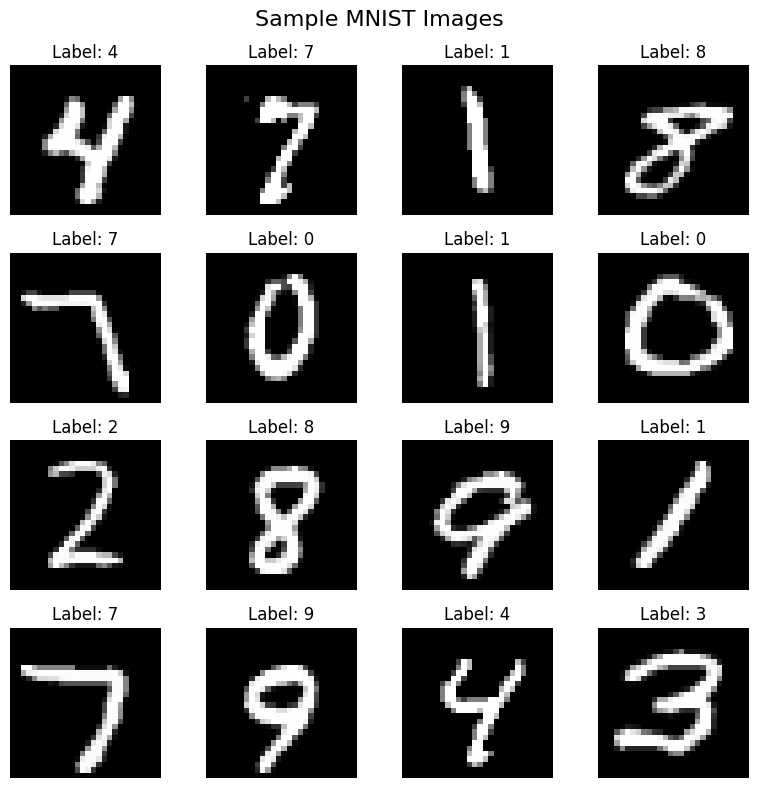

In [3]:


# Get a batch of images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Plot the first 16 images
plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
plt.suptitle("Sample MNIST Images", fontsize=16)
plt.tight_layout()
plt.show()


<ipython-input-4-e5b6255af81d>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Digit", data=label_df, palette="viridis")


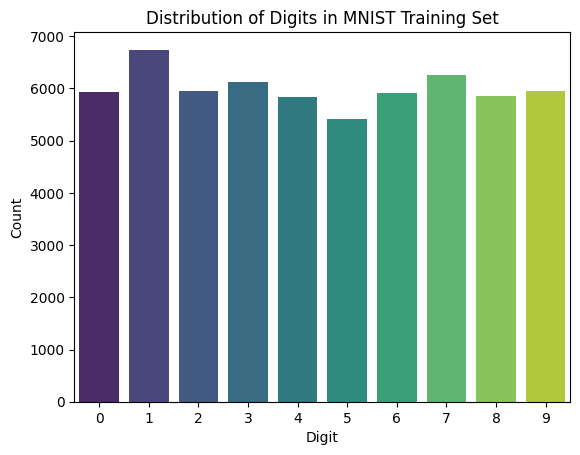

In [4]:


# Collect all labels from the full dataset
all_labels = [label for _, label in train_dataset]

# Create a bar plot of label distribution
label_df = pd.DataFrame(all_labels, columns=["Digit"])
sns.countplot(x="Digit", data=label_df, palette="viridis")
plt.title("Distribution of Digits in MNIST Training Set")
plt.xlabel("Digit")
plt.ylabel("Count")
plt.show()


In [5]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=10):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),  # 14x14
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # 7x7
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), # 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1), # 28x28
            nn.Tanh()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return z, x_recon


In [6]:
ae = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(ae.parameters(), lr=1e-3)

# Pretrain loop
for epoch in range(50):
    epoch_loss = 0
    for imgs, _ in tqdm(train_loader, desc=f"AE Epoch {epoch+1}"):
        imgs = imgs.to(device)
        _, recons = ae(imgs)
        loss = criterion(recons, imgs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {epoch_loss / len(train_loader):.4f}")


AE Epoch 1: 100%|██████████| 235/235 [00:14<00:00, 15.84it/s]


Epoch 1, Loss: 0.4120


AE Epoch 2: 100%|██████████| 235/235 [00:12<00:00, 18.34it/s]


Epoch 2, Loss: 0.1346


AE Epoch 3: 100%|██████████| 235/235 [00:12<00:00, 18.13it/s]


Epoch 3, Loss: 0.0989


AE Epoch 4: 100%|██████████| 235/235 [00:12<00:00, 18.25it/s]


Epoch 4, Loss: 0.0879


AE Epoch 5: 100%|██████████| 235/235 [00:14<00:00, 15.86it/s]


Epoch 5, Loss: 0.0818


AE Epoch 6: 100%|██████████| 235/235 [00:13<00:00, 18.03it/s]


Epoch 6, Loss: 0.0775


AE Epoch 7: 100%|██████████| 235/235 [00:12<00:00, 18.14it/s]


Epoch 7, Loss: 0.0744


AE Epoch 8: 100%|██████████| 235/235 [00:12<00:00, 18.26it/s]


Epoch 8, Loss: 0.0720


AE Epoch 9: 100%|██████████| 235/235 [00:12<00:00, 18.53it/s]


Epoch 9, Loss: 0.0700


AE Epoch 10: 100%|██████████| 235/235 [00:12<00:00, 18.47it/s]


Epoch 10, Loss: 0.0682


AE Epoch 11: 100%|██████████| 235/235 [00:12<00:00, 18.68it/s]


Epoch 11, Loss: 0.0666


AE Epoch 12: 100%|██████████| 235/235 [00:12<00:00, 18.30it/s]


Epoch 12, Loss: 0.0653


AE Epoch 13: 100%|██████████| 235/235 [00:13<00:00, 18.02it/s]


Epoch 13, Loss: 0.0641


AE Epoch 14: 100%|██████████| 235/235 [00:12<00:00, 18.24it/s]


Epoch 14, Loss: 0.0629


AE Epoch 15: 100%|██████████| 235/235 [00:13<00:00, 17.11it/s]


Epoch 15, Loss: 0.0620


AE Epoch 16: 100%|██████████| 235/235 [00:12<00:00, 18.08it/s]


Epoch 16, Loss: 0.0612


AE Epoch 17: 100%|██████████| 235/235 [00:13<00:00, 17.38it/s]


Epoch 17, Loss: 0.0604


AE Epoch 18: 100%|██████████| 235/235 [00:13<00:00, 17.79it/s]


Epoch 18, Loss: 0.0596


AE Epoch 19: 100%|██████████| 235/235 [00:13<00:00, 17.90it/s]


Epoch 19, Loss: 0.0590


AE Epoch 20: 100%|██████████| 235/235 [00:13<00:00, 17.99it/s]


Epoch 20, Loss: 0.0583


AE Epoch 21: 100%|██████████| 235/235 [00:13<00:00, 17.87it/s]


Epoch 21, Loss: 0.0577


AE Epoch 22: 100%|██████████| 235/235 [00:13<00:00, 17.95it/s]


Epoch 22, Loss: 0.0572


AE Epoch 23: 100%|██████████| 235/235 [00:13<00:00, 18.03it/s]


Epoch 23, Loss: 0.0567


AE Epoch 24: 100%|██████████| 235/235 [00:13<00:00, 17.90it/s]


Epoch 24, Loss: 0.0562


AE Epoch 25: 100%|██████████| 235/235 [00:12<00:00, 18.12it/s]


Epoch 25, Loss: 0.0558


AE Epoch 26: 100%|██████████| 235/235 [00:12<00:00, 18.36it/s]


Epoch 26, Loss: 0.0554


AE Epoch 27: 100%|██████████| 235/235 [00:12<00:00, 18.46it/s]


Epoch 27, Loss: 0.0551


AE Epoch 28: 100%|██████████| 235/235 [00:12<00:00, 18.35it/s]


Epoch 28, Loss: 0.0547


AE Epoch 29: 100%|██████████| 235/235 [00:12<00:00, 18.09it/s]


Epoch 29, Loss: 0.0543


AE Epoch 30: 100%|██████████| 235/235 [00:13<00:00, 17.63it/s]


Epoch 30, Loss: 0.0540


AE Epoch 31: 100%|██████████| 235/235 [00:13<00:00, 17.72it/s]


Epoch 31, Loss: 0.0537


AE Epoch 32: 100%|██████████| 235/235 [00:12<00:00, 18.33it/s]


Epoch 32, Loss: 0.0533


AE Epoch 33: 100%|██████████| 235/235 [00:12<00:00, 18.44it/s]


Epoch 33, Loss: 0.0532


AE Epoch 34: 100%|██████████| 235/235 [00:12<00:00, 18.53it/s]


Epoch 34, Loss: 0.0529


AE Epoch 35: 100%|██████████| 235/235 [00:12<00:00, 18.38it/s]


Epoch 35, Loss: 0.0527


AE Epoch 36: 100%|██████████| 235/235 [00:12<00:00, 18.19it/s]


Epoch 36, Loss: 0.0524


AE Epoch 37: 100%|██████████| 235/235 [00:13<00:00, 17.48it/s]


Epoch 37, Loss: 0.0523


AE Epoch 38: 100%|██████████| 235/235 [00:12<00:00, 18.23it/s]


Epoch 38, Loss: 0.0520


AE Epoch 39: 100%|██████████| 235/235 [00:12<00:00, 18.33it/s]


Epoch 39, Loss: 0.0519


AE Epoch 40: 100%|██████████| 235/235 [00:12<00:00, 18.23it/s]


Epoch 40, Loss: 0.0517


AE Epoch 41: 100%|██████████| 235/235 [00:12<00:00, 18.48it/s]


Epoch 41, Loss: 0.0515


AE Epoch 42: 100%|██████████| 235/235 [00:12<00:00, 18.70it/s]


Epoch 42, Loss: 0.0513


AE Epoch 43: 100%|██████████| 235/235 [00:12<00:00, 18.21it/s]


Epoch 43, Loss: 0.0512


AE Epoch 44: 100%|██████████| 235/235 [00:12<00:00, 18.32it/s]


Epoch 44, Loss: 0.0510


AE Epoch 45: 100%|██████████| 235/235 [00:13<00:00, 18.05it/s]


Epoch 45, Loss: 0.0509


AE Epoch 46: 100%|██████████| 235/235 [00:12<00:00, 18.47it/s]


Epoch 46, Loss: 0.0507


AE Epoch 47: 100%|██████████| 235/235 [00:12<00:00, 18.38it/s]


Epoch 47, Loss: 0.0506


AE Epoch 48: 100%|██████████| 235/235 [00:12<00:00, 18.29it/s]


Epoch 48, Loss: 0.0505


AE Epoch 49: 100%|██████████| 235/235 [00:12<00:00, 18.35it/s]


Epoch 49, Loss: 0.0504


AE Epoch 50: 100%|██████████| 235/235 [00:12<00:00, 18.25it/s]

Epoch 50, Loss: 0.0502


In [7]:
def target_distribution(q):
    weight = q**2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

class DEC:
    def __init__(self, model, n_clusters=10, alpha=1.0):
        self.model = model
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.cluster_centers = nn.Parameter(
            torch.randn(n_clusters, 10, dtype=torch.float32).to(device)
        )

    def soft_assign(self, z):
        z = z.float()
        dist = torch.cdist(z, self.cluster_centers, p=2) ** 2
        num = (1.0 + dist / self.alpha) ** ((self.alpha + 1.0) / -2)
        return (num.T / num.sum(1)).T  # shape: (batch, n_clusters)

    def kl_loss(self, q, p):
        return torch.nn.functional.kl_div(q.log(), p, reduction='batchmean')

# Step 1: Extract embeddings
ae.eval()
all_embeddings = []
all_labels = []

with torch.no_grad():
    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        z, _ = ae(imgs)
        all_embeddings.append(z.cpu())
        all_labels.append(labels)

embeddings = torch.cat(all_embeddings)
labels = torch.cat(all_labels)

# Step 2: Init cluster centers with KMeans
kmeans = KMeans(n_clusters=10, n_init=20)
y_pred = kmeans.fit_predict(embeddings)
dec = DEC(ae, 10)
dec.cluster_centers.data = torch.tensor(
    kmeans.cluster_centers_, dtype=torch.float32, device=device
)

# Step 3: DEC training
optimizer = optim.Adam(
    [{'params': ae.encoder.parameters()}, {'params': dec.cluster_centers}], lr=1e-3
)

for epoch in range(50):
    epoch_loss = 0
    for imgs, _ in tqdm(train_loader, desc=f"DEC Epoch {epoch+1}"):
        imgs = imgs.to(device)
        z, _ = ae(imgs)
        q = dec.soft_assign(z)
        p = target_distribution(q.detach())
        loss = dec.kl_loss(q, p)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"[DEC] Epoch {epoch+1}, Loss: {epoch_loss / len(train_loader):.4f}")


DEC Epoch 1: 100%|██████████| 235/235 [00:13<00:00, 17.79it/s]


[DEC] Epoch 1, Loss: 0.2316


DEC Epoch 2: 100%|██████████| 235/235 [00:12<00:00, 18.77it/s]


[DEC] Epoch 2, Loss: 0.2056


DEC Epoch 3: 100%|██████████| 235/235 [00:12<00:00, 18.59it/s]


[DEC] Epoch 3, Loss: 0.1934


DEC Epoch 4: 100%|██████████| 235/235 [00:12<00:00, 18.49it/s]


[DEC] Epoch 4, Loss: 0.1854


DEC Epoch 5: 100%|██████████| 235/235 [00:12<00:00, 18.44it/s]


[DEC] Epoch 5, Loss: 0.1792


DEC Epoch 6: 100%|██████████| 235/235 [00:12<00:00, 18.51it/s]


[DEC] Epoch 6, Loss: 0.1740


DEC Epoch 7: 100%|██████████| 235/235 [00:13<00:00, 17.46it/s]


[DEC] Epoch 7, Loss: 0.1698


DEC Epoch 8: 100%|██████████| 235/235 [00:12<00:00, 18.33it/s]


[DEC] Epoch 8, Loss: 0.1663


DEC Epoch 9: 100%|██████████| 235/235 [00:12<00:00, 18.13it/s]


[DEC] Epoch 9, Loss: 0.1624


DEC Epoch 10: 100%|██████████| 235/235 [00:13<00:00, 18.01it/s]


[DEC] Epoch 10, Loss: 0.1593


DEC Epoch 11: 100%|██████████| 235/235 [00:12<00:00, 18.89it/s]


[DEC] Epoch 11, Loss: 0.1562


DEC Epoch 12: 100%|██████████| 235/235 [00:12<00:00, 18.74it/s]


[DEC] Epoch 12, Loss: 0.1533


DEC Epoch 13: 100%|██████████| 235/235 [00:12<00:00, 18.90it/s]


[DEC] Epoch 13, Loss: 0.1505


DEC Epoch 14: 100%|██████████| 235/235 [00:12<00:00, 18.88it/s]


[DEC] Epoch 14, Loss: 0.1481


DEC Epoch 15: 100%|██████████| 235/235 [00:12<00:00, 19.24it/s]


[DEC] Epoch 15, Loss: 0.1456


DEC Epoch 16: 100%|██████████| 235/235 [00:12<00:00, 19.35it/s]


[DEC] Epoch 16, Loss: 0.1435


DEC Epoch 17: 100%|██████████| 235/235 [00:12<00:00, 18.86it/s]


[DEC] Epoch 17, Loss: 0.1415


DEC Epoch 18: 100%|██████████| 235/235 [00:12<00:00, 18.81it/s]


[DEC] Epoch 18, Loss: 0.1392


DEC Epoch 19: 100%|██████████| 235/235 [00:12<00:00, 18.86it/s]


[DEC] Epoch 19, Loss: 0.1375


DEC Epoch 20: 100%|██████████| 235/235 [00:12<00:00, 18.83it/s]


[DEC] Epoch 20, Loss: 0.1356


DEC Epoch 21: 100%|██████████| 235/235 [00:12<00:00, 18.93it/s]


[DEC] Epoch 21, Loss: 0.1341


DEC Epoch 22: 100%|██████████| 235/235 [00:12<00:00, 18.71it/s]


[DEC] Epoch 22, Loss: 0.1328


DEC Epoch 23: 100%|██████████| 235/235 [00:12<00:00, 18.89it/s]


[DEC] Epoch 23, Loss: 0.1309


DEC Epoch 24: 100%|██████████| 235/235 [00:12<00:00, 18.89it/s]


[DEC] Epoch 24, Loss: 0.1298


DEC Epoch 25: 100%|██████████| 235/235 [00:12<00:00, 18.58it/s]


[DEC] Epoch 25, Loss: 0.1282


DEC Epoch 26: 100%|██████████| 235/235 [00:12<00:00, 18.43it/s]


[DEC] Epoch 26, Loss: 0.1273


DEC Epoch 27: 100%|██████████| 235/235 [00:12<00:00, 18.56it/s]


[DEC] Epoch 27, Loss: 0.1259


DEC Epoch 28: 100%|██████████| 235/235 [00:12<00:00, 18.77it/s]


[DEC] Epoch 28, Loss: 0.1249


DEC Epoch 29: 100%|██████████| 235/235 [00:12<00:00, 18.72it/s]


[DEC] Epoch 29, Loss: 0.1234


DEC Epoch 30: 100%|██████████| 235/235 [00:13<00:00, 17.69it/s]


[DEC] Epoch 30, Loss: 0.1225


DEC Epoch 31: 100%|██████████| 235/235 [00:12<00:00, 18.35it/s]


[DEC] Epoch 31, Loss: 0.1214


DEC Epoch 32: 100%|██████████| 235/235 [00:12<00:00, 18.64it/s]


[DEC] Epoch 32, Loss: 0.1203


DEC Epoch 33: 100%|██████████| 235/235 [00:12<00:00, 18.35it/s]


[DEC] Epoch 33, Loss: 0.1193


DEC Epoch 34: 100%|██████████| 235/235 [00:12<00:00, 18.47it/s]


[DEC] Epoch 34, Loss: 0.1183


DEC Epoch 35: 100%|██████████| 235/235 [00:12<00:00, 18.85it/s]


[DEC] Epoch 35, Loss: 0.1178


DEC Epoch 36: 100%|██████████| 235/235 [00:12<00:00, 18.12it/s]


[DEC] Epoch 36, Loss: 0.1165


DEC Epoch 37: 100%|██████████| 235/235 [00:12<00:00, 18.99it/s]


[DEC] Epoch 37, Loss: 0.1157


DEC Epoch 38: 100%|██████████| 235/235 [00:12<00:00, 19.01it/s]


[DEC] Epoch 38, Loss: 0.1148


DEC Epoch 39: 100%|██████████| 235/235 [00:12<00:00, 18.88it/s]


[DEC] Epoch 39, Loss: 0.1141


DEC Epoch 40: 100%|██████████| 235/235 [00:12<00:00, 18.90it/s]


[DEC] Epoch 40, Loss: 0.1134


DEC Epoch 41: 100%|██████████| 235/235 [00:12<00:00, 18.61it/s]


[DEC] Epoch 41, Loss: 0.1122


DEC Epoch 42: 100%|██████████| 235/235 [00:12<00:00, 18.71it/s]


[DEC] Epoch 42, Loss: 0.1114


DEC Epoch 43: 100%|██████████| 235/235 [00:12<00:00, 18.61it/s]


[DEC] Epoch 43, Loss: 0.1108


DEC Epoch 44: 100%|██████████| 235/235 [00:12<00:00, 18.66it/s]


[DEC] Epoch 44, Loss: 0.1101


DEC Epoch 45: 100%|██████████| 235/235 [00:12<00:00, 18.59it/s]


[DEC] Epoch 45, Loss: 0.1092


DEC Epoch 46: 100%|██████████| 235/235 [00:12<00:00, 18.36it/s]


[DEC] Epoch 46, Loss: 0.1084


DEC Epoch 47: 100%|██████████| 235/235 [00:12<00:00, 18.65it/s]


[DEC] Epoch 47, Loss: 0.1081


DEC Epoch 48: 100%|██████████| 235/235 [00:12<00:00, 18.32it/s]


[DEC] Epoch 48, Loss: 0.1073


DEC Epoch 49: 100%|██████████| 235/235 [00:12<00:00, 18.36it/s]


[DEC] Epoch 49, Loss: 0.1064


DEC Epoch 50: 100%|██████████| 235/235 [00:12<00:00, 18.64it/s]

[DEC] Epoch 50, Loss: 0.1059


In [8]:

ae.eval()
with torch.no_grad():
    all_z = []
    for imgs, _ in train_loader:
        z, _ = ae(imgs.to(device))
        all_z.append(z.cpu())
    z = torch.cat(all_z).numpy()

# KMeans clustering
kmeans = KMeans(n_clusters=10, n_init=20).fit(z)
labels_pred = kmeans.labels_

# Evaluation metrics
sil = silhouette_score(z, labels_pred)
db = davies_bouldin_score(z, labels_pred)
chi = calinski_harabasz_score(z, labels_pred)

print(f"Silhouette Score:         {sil:.4f}")
print(f"Davies-Bouldin Index:     {db:.4f}")
print(f"Calinski-Harabasz Index:  {chi:.4f}")


Silhouette Score:         0.7529
Davies-Bouldin Index:     0.3257
Calinski-Harabasz Index:  175165.3281


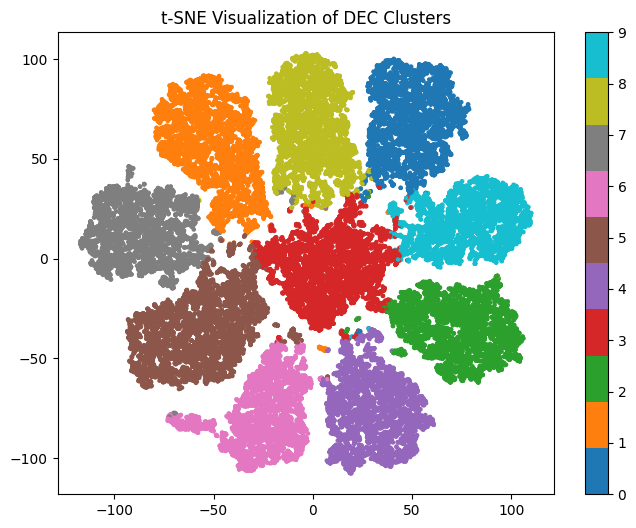

In [9]:
tsne = TSNE(n_components=2, random_state=42)
z_2d = tsne.fit_transform(z)

plt.figure(figsize=(8,6))
plt.scatter(z_2d[:, 0], z_2d[:, 1], c=kmeans.labels_, cmap='tab10', s=5)
plt.title("t-SNE Visualization of DEC Clusters")
plt.colorbar()
plt.show()


In [10]:
import pickle

with open("dec_results.pkl", "wb") as f:
    pickle.dump({
        "embeddings": z,
        "labels": labels.numpy(),
        "preds": kmeans.labels_,
        "silhouette": sil,
        "db_score": db
    }, f)
torch.save(ae.state_dict(), "autoencoder_mnist.pth")
